In [1]:
# This reload library is just used for developing the REPUBLIC hOCR parser 
# and can be removed once this module is stable.
%reload_ext autoreload
%autoreload 2

# This is needed to add the repo dir to the path so jupyter
# can load the modules in the scripts directory from the notebooks
import os
import sys
repo_dir = os.path.split(os.getcwd())[0]
print(repo_dir)
if repo_dir not in sys.path:
    sys.path.append(repo_dir)
    
import numpy as np
import pandas as pd
import json
import csv
from collections import Counter
import gzip
import os
import math
import arviz as az
import matplotlib.pyplot as plt

data_dir = '/Volumes/Samsung_T5/Data/Book-Reviews/GoodReads/'
data_dir = '../data/GoodReads/'

author_file = os.path.join(data_dir, 'goodreads_book_authors.csv.gz') # author information
book_file = os.path.join(data_dir, 'goodreads_books.csv.gz') # basic book metadata
genre_file = os.path.join(data_dir, 'goodreads_book_genres_initial.csv.gz') # book genre information
review_file = os.path.join(data_dir, 'goodreads_reviews_dedup-no_text.csv.gz') # excludes text to save memory
review_filtered_file = os.path.join(data_dir, 'goodreads_reviews_dedup_filtered-no_text.csv.gz') # excludes text and non-reviews
review_text_file = os.path.join(data_dir, 'goodreads_reviews_dedup.csv.gz') # includes text



/Users/marijnkoolen/Code/Huygens/scale


In the notebook [Filtering Goodreads Reviews](./Filtering-Goodreads-Reviews.ipynb) we detail the steps to filter out some non-reviews and include an argument why this is acceptable and even necessary.

A plot of the review length distribution revealed that there are a few lengths (in number of characters) with high peaks in the frequency distribution. E.g. there are many more reviews of length 3 than expected given the rest of the distribution. Inspection revealed that many of those 3-character reviews contain only a rating, like '3.5' or '4.5'.



In [2]:
review_df = pd.read_csv(review_filtered_file, sep='\t', compression='gzip')

review_df


,user_id,book_id,review_id,rating,date_added,date_updated,read_at,started_at,n_votes,n_comments,review_length
0,8842281e1d1347389f2ab93d60773d4d,24375664,5cd416f3efc3f944fce4ce2db2290d5e,5,Fri Aug 25 13:55:02 -0700 2017,Mon Oct 09 08:55:59 -0700 2017,Sat Oct 07 00:00:00 -0700 2017,Sat Aug 26 00:00:00 -0700 2017,16,0,968
1,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1,2086
2,8842281e1d1347389f2ab93d60773d4d,6392944,5e212a62bced17b4dbe41150e5bb9037,3,Mon Jul 24 02:48:17 -0700 2017,Sun Jul 30 09:28:03 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,Mon Jul 24 00:00:00 -0700 2017,6,0,474
3,8842281e1d1347389f2ab93d60773d4d,22078596,fdd13cad0695656be99828cd75d6eb73,4,Mon Jul 24 02:33:09 -0700 2017,Sun Jul 30 10:23:54 -0700 2017,Sun Jul 30 15:42:05 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,22,4,962
4,8842281e1d1347389f2ab93d60773d4d,6644782,bd0df91c9d918c0e433b9ab3a9a5c451,4,Mon Jul 24 02:28:14 -0700 2017,Thu Aug 24 00:07:20 -0700 2017,Sat Aug 05 00:00:00 -0700 2017,Sun Jul 30 00:00:00 -0700 2017,8,0,420
...,...,...,...,...,...,...,...,...,...,...,...
15616192,d0f6d1a4edcab80a6010cfcfeda4999f,1656001,b3d9a00405f7e96752d67b85deda4c7d,4,Mon Jun 04 18:08:44 -0700 2012,Tue Jun 26 18:58:46 -0700 2012,NaN,Sun Jun 10 00:00:00 -0700 2012,0,1,299
15616193,594c86711bd7acdaf655d102df52a9cb,10024429,2bcba3579aa1d728e664de293e16aacf,5,Fri Aug 01 18:46:18 -0700 2014,Fri Aug 01 18:47:07 -0700 2014,NaN,NaN,0,0,71
15616194,594c86711bd7acdaf655d102df52a9cb,6721437,7c1a7fcc2614a1a2a29213c11c991083,3,Tue Aug 27 12:49:25 -0700 2013,Tue Aug 27 12:53:46 -0700 2013,NaN,NaN,0,0,224
15616195,594c86711bd7acdaf655d102df52a9cb,15788197,74a9f9d1db09a90aae3a5acea68c6593,2,Fri May 03 13:06:15 -0700 2013,Fri May 03 15:35:39 -0700 2013,Fri May 03 15:35:39 -0700 2013,Fri May 03 00:00:00 -0700 2013,0,0,108


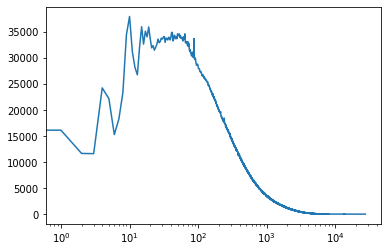

In [119]:

review_df.review_length.value_counts().sort_index().plot(logx=True)



There are still several strange peaks and dips for reviews below 30 characters. We will leave these for now.



In [ ]:
# alternative ways of plotting this
#review_df.review_length.hist(bins=100, log=True)


Why is it so important to talked about the type of distribution?

First, we want to be able to compare different subsets of reviews on various characteristics and need to know if it is fair and valid to make each comparison. E.g. do reviews on Amazon differ from Goodreads reviews for the same book 1) in terms of the ratings they give to books or 2) in terms of the sentiment expressed or 3) what aspects of a book the sentiment is expressed about (e.g. the characters or the plot or the writing style)?

To be able to compare fairly how much sentiment is expressed, one may want to check that these sets reviews are representative samples of the large sets of all reviews on Amazon and all reviews on Goodreads. One thing to check is that they cover reviews of different lengths. As individual reviews can differ strongly in length (some are just a few words, others are thousands of words long), comparing individual lengths is not meaningful. A more meaningful way is to compare their distributions. Do they roughly contain the same number of reviews of different lengths? 

Second, it helps us spot anomalies in a dataset. The first distribution plot of the unfiltered reviews revealed strange peaks in a distrubtion that, apart from those peaks, looks like a log-normal distribution. Knowing that most characteristics of large samples of documents tend to follow a known distribution, and knowing what these look like, helps us to spot these anomalies and to determine if and how these anomalies should be dealt with.

Third, it helps us to think more deeply about the **causal factors that play a role in the process of creating the documents or elements of our datasets**. This is where qualitative **domain knowledge and expertise** is extremely valuable and can be connected to quantitive aspects of the domain. 


### Shapes and Characteristics of Distributions

Many naturally occuring frequency distributions can be (more or less) recognized by their shape. These shapes are important to understand, as they can tell us a lot about what kinds of questions we can ask about them, and about mechanisms and causal factors that contribute to such distributions. There is a typology of distributions that give us a toolbox to discuss and compare sets of reviews.

For instance, with book reviews, we may ask why most books have between 10 and 300 characters and not much more, what the average length of reviews is, and what the variation in lengths is. Knowing the average and variation, we can also say whether a specific review is long, short or average. It gives us a way to make comparisons of subsets. For instance, are the lengths of reviews stable over time, or they changing? Are reviews of thrillers different in length than reviews of other genres?

Below we take a small detour to discuss normal distributions. The review lengths follow a different type of distribution, namely a so-called *log-normal* distributions. We will discuss this type and how it helps us understand the nature of different aspects of reviews after the detour on normal distributions.

#### Normal Distributions

The perhaps most common and well-known distribution is the bell-shaped [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution). Most data points are concentrated around the average value, and large deviations from that average value are rare.

How do normal distributions come about? Richard McElreath's wonderful book [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/) has very useful description and example of processes that lead to normal distributions. In processes where many factors contribute a small amount to the total, factors that contribute less and factors that contribute more, tend to cancel each other. If you throw two six-sided die you can throw between 2 and 12 eyes. Although the individual throws can deviate as much as 10 eyes from each other, over hundreds of throws, the average number of eyes in a single throw will centre around 7, the average and middle value. 

As another example, let's look at the distribution of human heights. We'll simulate a number of human heights using several simplifying assumptions (this is based on an example from the Statistical Rethinking book):

- The height of the human population is normally distributed (this is approximately true, but not exactly).
- There is a single *mean* height for the entire population (e.g. no differences between gender or between adults and children), and a single *variance*.
- The mean or average height of the population is 178 centimeters
- The standard deviation is 20 centimeters

First, we show a random sample of 10 human heights.

In [6]:
np.random.normal(178, 20, 10)

array([162.30863612, 178.60236851, 190.72033523, 180.67548648,
       167.97493583, 193.11398516, 169.3978602 , 144.33246675,
       184.56059913, 189.58732649])

Most of these ten values don't deviate far from to 178. Re-running the cell will generate another 10 random values. In most cases, this will result in another set of values that are close to 178.

Below we generate a larger samples and look at the shape of the distribution.


In [7]:
from scipy import stats

# create a sample of 10,000 human heights
sample = np.random.normal(178, 20, 100000)
print(f'The shortest person in the sample is {sample.min(): >.2f} cm tall.')
print(f'The tallest person in the sample is {sample.max(): >.2f} cm tall.')
print()
print(f'The median height in the sample is {np.median(sample): >.2f} cm tall.')
print(f'The average person in the sample is {sample.mean(): >.2f} cm tall.')
print()
print(f'The standard deviation of the sample is {sample.std(): >.2f} cm tall.')


The shortest person in the sample is 87.54 cm tall.
The tallest person in the sample is 267.66 cm tall.

The median height in the sample is 178.09 cm tall.
The average person in the sample is 178.02 cm tall.

The standard deviation of the sample is 19.94 cm tall.


Plotting these as a histogram, we should get the familiar bell-shaped distribution.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7febfe6f15d0>],
      dtype=object)

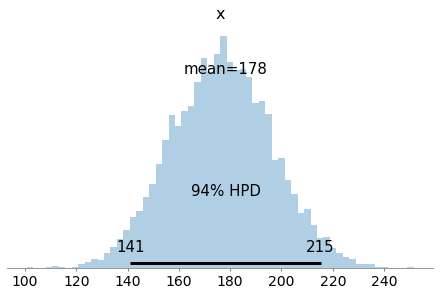

In [85]:
import arviz as az

az.plot_posterior(sample, kind='hist')

One important characteristic of normal distributions is that they are symmetric around the mean. That is, the number of data points below the mean is roughly the same as the number of data points above the mean. 

#### Sample Size and Stability

The shortest and tallest persons in the sample deviate about the same amount from the mean of 178. The median person (i.e., if all people in the sample are ranked by height from low to high, the median is the person in the middle) is very close the average or mean height of 178cm. 

This is the case for samples of 100,000 heights, but also samples of 10,000 heights or 10,000,000 heights. For very small samples, the mean may differ more from 178 because there are not enough random draws to cancel out the individual contributions that may deviate strongly from each other. But in general, 100 heights is enough to establish an accurate estimate of the mean and variance, regardless of whether the variance is 10 or 50 centimeters. 

In [5]:
for sample_size in [1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]:
    sample = np.random.normal(178, 10, sample_size)
    print(f'Sample size: {sample_size: >8}, height average: {sample.mean(): >.2f}, std. dev.: {sample.std(): >5.2f}')


Sample size:        1, height average: 178.06, std. dev.:  0.00
Sample size:       10, height average: 178.44, std. dev.: 13.72
Sample size:      100, height average: 179.19, std. dev.:  9.16
Sample size:     1000, height average: 177.99, std. dev.: 10.04
Sample size:    10000, height average: 177.98, std. dev.:  9.99
Sample size:   100000, height average: 178.05, std. dev.:  9.96
Sample size:  1000000, height average: 178.02, std. dev.:  9.99
Sample size: 10000000, height average: 178.00, std. dev.: 10.00


#### The Log-Normal Distribution and Review Lengths

Now we go back to the review lengths and the *log-normal* distribution. 

The *log-normal* distribution of a numeric characteristic (e.g. review length, number of reviews per book, author or genre, etc.) is a normal distribution for the logarithm of that numeric characteristic. That is, for review length, the logarithm of review lengths is normally distributed. 

If we know that the mean value and the standard deviation are important to describe the distribution, for a log-normal distribution, the mean value is the mean of the logarithm of each of the values. 

In [166]:
import math

#review_df = review_df[review_df.review_length > 0]
#review_df['review_log_length'] = review_df.review_length.apply(math.log)
print('normal length mean:', review_df.review_length.mean())
print('normal length median:', np.median(review_df.review_length))


normal length mean: 708.7728870409544
normal length median: 342.0


normal length mean: 708.7728870409544
normal length median: 342.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe84d4aa2d0>],
      dtype=object)

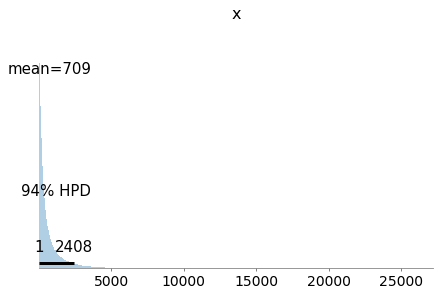

In [165]:
# plotting the histogram with the 94% interval (this takes a long time and a LOT of memory)

az.plot_posterior(np.array(review_df.review_length), kind='hist')

The mean length of reviews is 708 characters, but this cannot be interpreted in the same way as the mean height of people shown above. In the case of human height, which is normaly distributed, roughly half the people in the sample are below the average height, and the other half are above it (the mean is also almost the same as the median). 

But in a log-normal distribution this is not the case. The mean is much higher than the median, because there are some very long outlier reviews that contribute disproportionately to the mean. Remember that in normal-distribution processes, all factors have a small positive or negative contribution w.r.t. the total, which tend to cancel each other out, such that most data points end up near the mean. There is no possible way for a single very short review to compensate for a single very long review. Review lengths cannot be negative.

As a consequence, log-normal distributed data is not symmetric around the mean at all:

In [129]:
print('number of reviews above average length:', len(review_df[review_df.review_length < 708]))

number of reviews above average length: 10928752


In [128]:
print('number of reviews above average length:', len(review_df[review_df.review_length >= 708]))

number of reviews above average length: 4680507


Roughly two thirds are below the average and one third is above it, and most reviews are either a lot shorter or longer than 708 characters. But if we use the log-length, the mean is much closer to the median and the distribution is more symmetric around the mean.


In [170]:
print(f'log-length mean: {review_df.review_log_length.mean(): >.2f}')
print(f'log-length median: {np.median(review_df.review_log_length): >.2f}\n')
print(f'number of reviews below mean log-length: {len(review_df[review_df.review_log_length <= 5.76])}')
print(f'number of reviews above mean log-length: {len(review_df[review_df.review_log_length > 5.76])}\n')

print(f'The mean log-length corresponds to {int(math.exp(review_df.review_log_length.mean()))} characters')
print(f'The median log-length corresponds to {int(math.exp(np.median(review_df.review_log_length)))} characters\n')

print('number of reviews below mean log-length of 316 characters:', len(review_df[review_df.review_length <= 316]))
print('number of reviews above mean log-length of 316 characters:', len(review_df[review_df.review_length > 316]))


log-length mean: 5.76
log-length median: 5.83

number of reviews below mean log-length: 7477556
number of reviews above mean log-length: 8131703

The mean log-length corresponds to 316 characters
The median log-length corresponds to 341 characters

number of reviews below mean log-length of 316 characters: 7463623
number of reviews above mean log-length of 316 characters: 8145636


The average log-length is a better divider of the reviews in terms of length. A log-length of 5.76 corresponds to a character length of 316 characters (going back from the logarithm of a number to the number itself requires taking the exponent of the logarithm). 

This average length, calculated as the exponent of the log-lengths, is an equally good divider. 

It is also important to know that, **because log-normaly distributed data has larger deviations, this mean it requires a larger sample size** to establish accurate mean and standard deviation. Whereas the human heights examples showed a good estimate of the real mean and standard deviation in a sample of 100 heights, it requires a significantly larger sample to get a good estimate of review length:

In [162]:
for sample_size in [10, 10, 10, 100, 100, 100, 1000, 1000, 1000, 10000, 100000, 1000000, 10000000]:
    sample_df = review_df.sample(sample_size)
    mean = sample_df.review_length.mean()
    median = np.median(sample_df.review_length)
    std = sample_df.review_length.std()
    mean_log = sample_df.review_log_length.mean()
    median_log = np.median(sample_df.review_log_length)
    mean_exp_log = int(math.exp(mean_log))
    std_log = sample_df.review_log_length.std()
    print(f'Sample size: {sample_size: >8} mean (median) length: {mean: >7.2f} ({median: >7.2f}) mean log-length (median): {mean_log: >4.2f} ({median_log: >4.2f}) chars: {mean_exp_log: >3}')
    
    

Sample size:       10 mean (median) length:  488.10 ( 316.50) mean log-length (median): 5.54 (5.74) chars: 253
Sample size:       10 mean (median) length: 1460.70 ( 226.50) mean log-length (median): 5.81 (5.32) chars: 334
Sample size:       10 mean (median) length:  943.80 (1003.50) mean log-length (median): 6.41 (6.89) chars: 608
Sample size:      100 mean (median) length:  739.41 ( 402.50) mean log-length (median): 5.90 (6.00) chars: 363
Sample size:      100 mean (median) length:  607.50 ( 390.50) mean log-length (median): 5.76 (5.97) chars: 316
Sample size:      100 mean (median) length:  672.19 ( 360.00) mean log-length (median): 5.68 (5.89) chars: 293
Sample size:     1000 mean (median) length:  719.95 ( 355.00) mean log-length (median): 5.75 (5.87) chars: 312
Sample size:     1000 mean (median) length:  733.26 ( 356.00) mean log-length (median): 5.77 (5.87) chars: 319
Sample size:     1000 mean (median) length:  692.47 ( 363.00) mean log-length (median): 5.77 (5.89) chars: 320
S

In the samples above, all sample sizes below 10,000 are unstable (different samples of the same size have quite different means and variance). 


### Number of Reviews per Book

Next, we look at the number of reviews per book. Popular books get reviewed much more often than obscure books, resulting again in a skewed distribution. Most books have only one or a few reviews, and a small group has very many reviews. 

This distribution has yet another shape and different characteristics. Below we explore how **scale has a large effect on standard descriptive statistics of such a distribution and why they are therefore not very meaningful**.


In [34]:
from helper import ecdf

review_df.book_id.value_counts()

11870085    20686
2767052     18573
7260188     13482
22557272    13285
6148028     11864
            ...  
34409199        1
18741622        1
1496682         1
13415128        1
28900843        1
Name: book_id, Length: 2073188, dtype: int64

The review dataset contains reviews for 2,073,188 distinct book titles. We note that different titles can be different editions of the same work, such as the hardcover, paperback and ebook editions, mass market paperbacks as well as critical editions. 

The most reviewed title has 20,686 reviews, but the vast majority of titles have only one review. Below we look at the distribution.

In [9]:
from collections import Counter

num_review_freq = Counter([count for count in review_df.book_id.value_counts()])

for num_reviews, book_count in num_review_freq.most_common(10):
    print(f'Number of books with {num_reviews: >2} reviews: {book_count: > 9}')



Number of books with  1 reviews:   1048030
Number of books with  2 reviews:    320533
Number of books with  3 reviews:    163093
Number of books with  4 reviews:    100090
Number of books with  5 reviews:     68924
Number of books with  6 reviews:     50270
Number of books with  7 reviews:     38766
Number of books with  8 reviews:     30490
Number of books with  9 reviews:     24803
Number of books with 10 reviews:     20473


There are over 1 million books with only a single review. That is half of the total of 2 million books. This is typical of User-Generated Content on the web (see references [1-3] below). Books that are promoted in shops and advertisements get more attention and are more visible than books that are not. As a consequence, more people have heard of these more visible books and are more likely to buy or borrow them and mention them to others, including via online reviews, which further boosts the visibility of these books. An affect like [preferential attachment] or [winner takes all] kicks in that causes a few books to become ever more popular, while the majority of other books remain relatively unknown. 

[1] M. Hundt, N. Nesselhauf, C. Biewer, Corpus linguistics and the web, in: Corpus linguisticsand the web, Brill Rodopi, 2007, pp. 1–5.

[2]  X. Ochoa, E. Duval, Quantitative analysis of user-generated content on the web, 2008.

[3]  J. Ratkiewicz, S. Fortunato, A. Flammini, F. Menczer, A. Vespignani, Characterizing andmodeling the dynamics of online popularity,  Physical review letters 105 (2010) 158701

If we plot the distribution of these review frequencies, we see a different shape:

<Figure size 720x72 with 0 Axes>

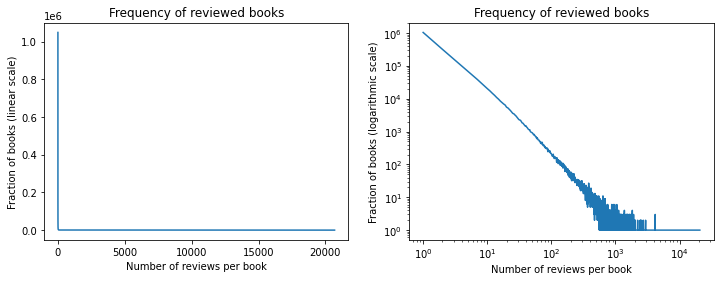

In [12]:
# get the review frequency as X axis data and the number of books with X reviews as Y axis data
x, y = zip(*num_review_freq.items())
# Turn the number of books into a proportion of the entire collection
y_prob = [y_val / sum(y) for y_val in y]

# Create two plots side-by-side to show the shape of the distribution in different scales
plt.figure(figsize=(10,1)) 
fig, axes = plt.subplots(1,2, figsize=(12,4))
ax1 = axes[0]
ax2 = axes[1]

# linear

ax1.plot(x,y)
ax1.set_title('Frequency of reviewed books')
ax1.set_xlabel('Number of reviews per book')
ax1.set_ylabel('Fraction of books (linear scale)')

# log
ax2.plot(x,y)
ax2.set_title('Frequency of reviewed books')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Number of reviews per book')
ax2.set_ylabel('Fraction of books (logarithmic scale)')
plt.show()


The plot on the left shows a blue line starting in the top left at just over 1 million, then goes straight down to 1 and moves to the right to just above 20,000 on the X-axis. This is to show that this distribution is heavily skewed to the left. Almost all books have only one or a few reviews. And because there are a handful of books with tens of thousands of reviews, the data points for books with up to 100 reviews are compressed into this single vertical blue line. It is impossible to see the datapoints for books with 2, 5, 19 or 36 reviews. 

A typical trick is to switch from a linear scale (the shift of the X-axis from 1 to 101 reviews is the same as the shift from 19,900 to 20,000 reviews) to a logarithmic scale, where the shift from 1 to 100 is the same as the shift from 100 to 10,000. This is shown in the plot on the right. Now the difference between 1, 2, 5, 19 and 36 reviews is more visible. The distribution shows a straight line, and because this a so-called *log-log* scale (both the X and Y axes use logarithmic scales), the straight line is a signal that this distribution follows a so-called **power-law**. A power-law distribution (also often referred to as *long-tail* distribution) has very different characteristics from a **normal** or **log-normal** distribution. 

For instance, where is with a normal distribution we speak of the average and standard deviation to understand what the distribution looks like, these statistics are not meaningful for power-law distributions. Although it is possible to calculate a *mean* value or the *variance*, these are misleading to use, because they depend on the sample size. 

In [28]:

def plot_sample_distribution(df, sample_size):
    sample_df = df.sample(sample_size) if sample_size < len(df) else df
    counts = sample_df.book_id.value_counts()
    print(f"Sample: {sample_size: >8}\tMean: {counts.mean(): >6.2f}\tMedian: {np.median(counts): >4}\tMin: {counts.min(): >3}\tMax: {counts.max(): >6}\tStd.dev: {counts.std(): >6.2f}")


sample_sizes = [100, 100, 100, 10000, 10000, 10000, 1000000, 10000000, 100000000]
for sample_size in sample_sizes:
    plot_sample_distribution(review_df, sample_size)

Sample:      100	Mean:   1.00	Median:  1.0	Min:   1	Max:      1	Std.dev:   0.00
Sample:      100	Mean:   1.00	Median:  1.0	Min:   1	Max:      1	Std.dev:   0.00
Sample:      100	Mean:   1.00	Median:  1.0	Min:   1	Max:      1	Std.dev:   0.00
Sample:    10000	Mean:   1.12	Median:  1.0	Min:   1	Max:     11	Std.dev:   0.58
Sample:    10000	Mean:   1.12	Median:  1.0	Min:   1	Max:     14	Std.dev:   0.58
Sample:    10000	Mean:   1.12	Median:  1.0	Min:   1	Max:     19	Std.dev:   0.55
Sample:  1000000	Mean:   2.49	Median:  1.0	Min:   1	Max:   1313	Std.dev:  10.02
Sample: 10000000	Mean:   6.08	Median:  1.0	Min:   1	Max:  13201	Std.dev:  49.97
Sample: 15616197	Mean:   7.53	Median:  1.0	Min:   1	Max:  20686	Std.dev:  69.59


The different sample sizes have different means, maximums and standard deviations. Here is the important thing: **in power-law distributed data, mean and variance tend to increase with sample size!**

The descriptive statistics that most of us are familiar, mean and variance, are useful ways to describe and reason about normally-distributed data, because in a large enough (random) sample, they are good approximations of the real mean and variance of the data-generating process. With larger samples the mean and variance are increasingly good approximations. But in power-law distributed data, no matter what sample size, the mean and variance as not good approximations, as they are dependent on the sample size: a one-million review sample has a much lower mean and variance than the full set of 15 million reviews, and those 15 million reviews are only a (non-random) sample of all the reviews that are published on Goodreads, with new reviews being published all the time. **But more importantly, they are also not useful descriptions of the data, because**:

1. There is usually very little centred around the mean (the vast majority of data points are below the mean).

2. The distribution is very not symmetric around the mean. The two sides of the mean have very different shapes and mass.

3. The standard deviation is usually much higher than the mean, so tells you nothing about what the distribution below the mean looks like. Nor does it capture well what is happening above the mean.
 


In [35]:
#counts = review_df.book_id.value_counts()
print('number of books with at least one review:', len(counts))
print('number of books with below average number of reviews:', len(counts[counts < 7.53]))
print('proportion of books with below average number of reviews:', len(counts[counts < 7.53]) / len(counts))

number of books with at least one review: 2073188
number of books with below average number of reviews: 1789706
proportion of books with below average number of reviews: 0.8632627624701668


Over 86% of books have fewer reviews than the mean so less than 14% have more than the mean. 

### Power-laws in correspondences

Power-law distributions are typical of user-generated content on the web, where popularity and availability effects cause frequency distributions to be increasingly skewed. 

But in many other types of data we the same patterns. For instance, the correspondences between people as archived in the Early Modern Letters Online digital collection.

Below we look at the number of letters send by individual authors and the number of letters received by addressees.

In [2]:

# read the merged letters file into a Pandas dataframe
merged_letters_file = '../data/emlo_letters.csv'
df = pd.read_csv(merged_letters_file, sep='\t')


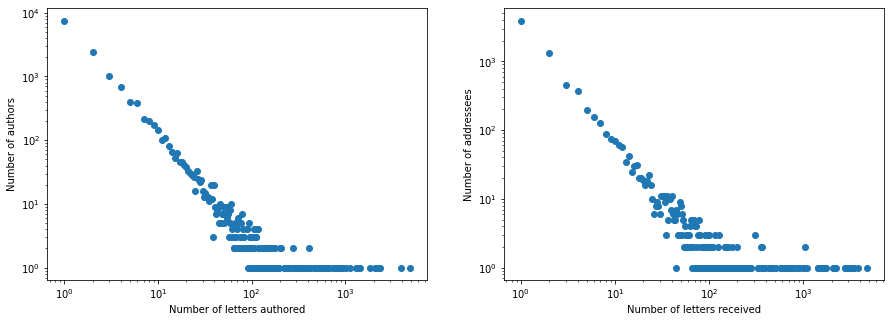

In [5]:
from collections import Counter

plt.subplots(1,2, figsize=(15,5))

# count the number of letters per author, 
# than count the number of authors with a specific number of letters
author_dist = Counter([count for count in df.author.value_counts()])
x_author, y_author = zip(*author_dist.items())
plt.subplot(1,2,1)
plt.scatter(x_author, y_author)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of letters authored')
plt.ylabel('Number of authors')

plt.subplot(1,2,2)
# count the number of letters per addressees, 
# than count the number of addressees with a specific number of letters
addressee_dist = Counter([count for count in df.addressee.value_counts()])
x_addressee, y_addressee = zip(*addressee_dist.items())
plt.scatter(x_addressee, y_addressee)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of letters received')
plt.ylabel('Number of addressees')
plt.show()


In [21]:
# the sizes of the individual collections also form a highly skewed distribution
df.collection.value_counts()



Bodleian card catalogue     48668
Groot, Hugo de               8034
Huygens, Constantijn         7120
Hartlib, Samuel              4719
Andreae, Johann Valentin     3696
                            ...  
Beeckman, Isaac                28
Dudley, Anne                   27
Vernon, Margaret               21
Baxter, Richard                 8
Culpeper, Cheney                3
Name: collection, Length: 93, dtype: int64